# Topics – Easy Topic Modeling in Python

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This notebook introduces an user-friendly workflow, basically containing data preprocessing, an implementation of the prototypic topic model **Latent Dirichlet Allocation** (LDA) which learns the relationships between words, topics, and documents, as well as multiple visualizations to explore the trained LDA model.

In this notebook, we're relying on the LDA implementation by [Allen Riddell](https://www.ariddell.org) called [**lda**](http://pythonhosted.org/lda/index.html). 

## First step: Installing dependencies

The following tutorial will explain how to perform LDA topic modeling with a programming library in Python. If you have not done so yet, please install all necessary libraries by executing one of the following cells.

### Windows

In [1]:
#!pip install -r requirements.txt

### macOS

In [2]:
#!pip3 install -r requirements.txt

### Linux

In [3]:
#!sudo pip3 install -r requirements.txt

## 1. Preprocessing

Let's not pay heed to any warnings right now and execute the following cell.

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Loading modules from DARIAH-Topics library
First, we have to get access to the functionalities of the library by importing them.

In [5]:
from dariah_topics import preprocessing
from dariah_topics import doclist
from dariah_topics import meta
from dariah_topics import mallet
from dariah_topics import visualization

#### Loading module for LDA
Furthermore, we will need some additional functions from external libraries.

In [6]:
import os
from bokeh.io import show
import lda

#### Activating inline output in Jupyter notebook
The following line will just tell the notebook to show graphics in the output frames.

In [7]:
%matplotlib inline

### 1.2. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using a folder of 'txt' documents provided with the package. For using your own corpus, change the path accordingly.

In [8]:
path = "grenzboten_sample"

#### List all documents in the folder
We begin by creating a list of all the documents in the folder specified above. That list will tell function `pre.read_from_txt()` (see below) which text documents to read.

In [9]:
pathdoclist = doclist.PathDocList(path)
document_list = pathdoclist.full_paths(as_str=True)

The current list of documents looks like this:

In [10]:
document_list

['grenzboten_sample\\Grenzboten_1844_Tagebuch_56.txt',
 'grenzboten_sample\\Grenzboten_1844_Tagebuch_70.txt',
 'grenzboten_sample\\Grenzboten_1844_Tagebuch_77.txt',
 'grenzboten_sample\\Grenzboten_1844_Tagebuch_82.txt',
 'grenzboten_sample\\Grenzboten_1844_Tagebuch_88.txt',
 'grenzboten_sample\\Grenzboten_1845_Tagebuch_52.txt',
 'grenzboten_sample\\Grenzboten_1845_Tagebuch_62.txt',
 'grenzboten_sample\\Grenzboten_1845_Tagebuch_81.txt',
 'grenzboten_sample\\Grenzboten_1845_Tagebuch_85.txt',
 'grenzboten_sample\\Grenzboten_1845_Tagebuch_93.txt',
 'grenzboten_sample\\Grenzboten_1846_Tagebuch_51.txt',
 'grenzboten_sample\\Grenzboten_1846_Tagebuch_72.txt',
 'grenzboten_sample\\Grenzboten_1846_Tagebuch_82.txt',
 'grenzboten_sample\\Grenzboten_1846_Tagebuch_88.txt',
 'grenzboten_sample\\Grenzboten_1846_Tagebuch_96.txt',
 'grenzboten_sample\\Grenzboten_1914_Kriegstagebuch_37.txt',
 'grenzboten_sample\\Grenzboten_1914_Kriegstagebuch_68.txt',
 'grenzboten_sample\\Grenzboten_1914_Kriegstagebuch_9

**Alternatively**, if we want to use other documents, or just a selction of those in the specified folder, we can define our own `doclist` by creating a list of strings containing paths to text files. For example, to use only the texts from 1916, we would define the list as

`
    doclist = ['grenzboten_sample/grenzboten_1916_Kriegstagebuch_41.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_48.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_49.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_69.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_81.txt']
`

#### Generate document labels

In [11]:
document_labels = pathdoclist.labels()
document_labels

['Grenzboten_1844_Tagebuch_56',
 'Grenzboten_1844_Tagebuch_70',
 'Grenzboten_1844_Tagebuch_77',
 'Grenzboten_1844_Tagebuch_82',
 'Grenzboten_1844_Tagebuch_88',
 'Grenzboten_1845_Tagebuch_52',
 'Grenzboten_1845_Tagebuch_62',
 'Grenzboten_1845_Tagebuch_81',
 'Grenzboten_1845_Tagebuch_85',
 'Grenzboten_1845_Tagebuch_93',
 'Grenzboten_1846_Tagebuch_51',
 'Grenzboten_1846_Tagebuch_72',
 'Grenzboten_1846_Tagebuch_82',
 'Grenzboten_1846_Tagebuch_88',
 'Grenzboten_1846_Tagebuch_96',
 'Grenzboten_1914_Kriegstagebuch_37',
 'Grenzboten_1914_Kriegstagebuch_68',
 'Grenzboten_1914_Kriegstagebuch_94',
 'Grenzboten_1914_Kriegstagebuch_95',
 'Grenzboten_1914_Kriegstagebuch_97',
 'Grenzboten_1915_Kriegstagebuch_33',
 'Grenzboten_1915_Kriegstagebuch_39',
 'Grenzboten_1915_Kriegstagebuch_73',
 'Grenzboten_1915_Kriegstagebuch_94',
 'Grenzboten_1915_Kriegstagebuch_99',
 'Grenzboten_1916_Kriegstagebuch_41',
 'Grenzboten_1916_Kriegstagebuch_48',
 'Grenzboten_1916_Kriegstagebuch_49',
 'Grenzboten_1916_Kriegsta

#### Optional: Accessing metadata

In case you want a more structured overview of your corpus, execute the following cell:

In [12]:
metadata = meta.fn2metadata(os.path.join(path, '*.txt'))
metadata

,author,basename,filename,title
0,Grenzboten,Grenzboten_1844_Tagebuch_56,grenzboten_sample\Grenzboten_1844_Tagebuch_56.txt,1844_Tagebuch_56
1,Grenzboten,Grenzboten_1844_Tagebuch_70,grenzboten_sample\Grenzboten_1844_Tagebuch_70.txt,1844_Tagebuch_70
2,Grenzboten,Grenzboten_1844_Tagebuch_77,grenzboten_sample\Grenzboten_1844_Tagebuch_77.txt,1844_Tagebuch_77
3,Grenzboten,Grenzboten_1844_Tagebuch_82,grenzboten_sample\Grenzboten_1844_Tagebuch_82.txt,1844_Tagebuch_82
4,Grenzboten,Grenzboten_1844_Tagebuch_88,grenzboten_sample\Grenzboten_1844_Tagebuch_88.txt,1844_Tagebuch_88
5,Grenzboten,Grenzboten_1845_Tagebuch_52,grenzboten_sample\Grenzboten_1845_Tagebuch_52.txt,1845_Tagebuch_52
6,Grenzboten,Grenzboten_1845_Tagebuch_62,grenzboten_sample\Grenzboten_1845_Tagebuch_62.txt,1845_Tagebuch_62
7,Grenzboten,Grenzboten_1845_Tagebuch_81,grenzboten_sample\Grenzboten_1845_Tagebuch_81.txt,1845_Tagebuch_81
8,Grenzboten,Grenzboten_1845_Tagebuch_85,grenzboten_sample\Grenzboten_1845_Tagebuch_85.txt,1845_Tagebuch_85
9,Grenzboten,Grenzboten_1845_Tagebuch_93,grenzboten_sample\Grenzboten_1845_Tagebuch_93.txt,1845_Tagebuch_93


#### Read listed documents from folder

In [13]:
corpus = preprocessing.read_from_txt(document_list)

At this point, the corpus is generator object.

### 1.3. Tokenize corpus
Your text files will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function the library provides is a simple unicode tokenizer. Depending on the corpus it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [14]:
tokens = [list(preprocessing.tokenize(document)) for document in list(corpus)]

At this point, each text is represented by a list of separate token strings. If we want to look e.g. into the first text (which has the index `0` as Python starts counting at 0) and show its first 10 words/tokens (that have the indeces `0:9` accordingly) by typing:

In [15]:
tokens[0][0:9]

['es',
 'berlin',
 'und',
 'paris',
 'sprcchscligkeir',
 'credit',
 'und',
 'religion',
 'priester']

### 1.4. Create a document-term matrix

The LDA topic model is based on a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of the corpus. To improve performance in large corpora, the matrix describes the frequency of terms that occur in the collection. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

In [16]:
doc_terms = preprocessing.create_doc_term_matrix(tokens, document_labels)
doc_terms

,die,der,und,in,den,von,zu,das,des,nicht,...,mördern,mühevolle,münch-bellinghausen,mühling,mühsame,mühsamen,müht,mül,müllers,a!s
Grenzboten_1844_Tagebuch_56,90.0,92.0,88.0,70.0,30.0,25.0,25.0,16.0,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_70,205.0,224.0,193.0,133.0,78.0,64.0,112.0,86.0,45.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_77,181.0,153.0,141.0,98.0,55.0,59.0,72.0,59.0,44.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_82,213.0,207.0,169.0,128.0,85.0,86.0,79.0,80.0,66.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_88,68.0,59.0,70.0,54.0,22.0,27.0,28.0,19.0,13.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_52,385.0,351.0,331.0,215.0,138.0,142.0,130.0,114.0,105.0,93.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_62,191.0,239.0,232.0,159.0,72.0,86.0,104.0,77.0,84.0,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_81,344.0,351.0,311.0,178.0,107.0,118.0,156.0,116.0,91.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_85,302.0,299.0,246.0,174.0,111.0,89.0,125.0,73.0,67.0,61.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_93,215.0,193.0,176.0,114.0,82.0,83.0,92.0,71.0,65.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5. Feature removal

In topic modeling, it is often usefull (if not vital) to remove some types before modeling. In this example, the 100 most frequent words and the *hapax legomena* in the corpus will be removed. This step is very easy to handle using the benefits of indexing.

#### List the 100 most frequent words

In [17]:
mfw100 = preprocessing.find_stopwords(doc_terms, 100)

These are the five most frequent words:

In [18]:
mfw100[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [19]:
hapax_list = preprocessing.find_hapax(doc_terms)

#### Optional: Use external stopwordlist

In [20]:
path_to_stopwordlist = "tutorial_supplementals/stopwords/de.txt"

extern_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r')]

#### Combine lists and remove content from `doc_term_matrix`

In [21]:
features = set(mfw100 + hapax_list + extern_stopwords)
doc_terms = preprocessing.remove_features_from_df(doc_terms, features)

Finally, this is how your clean corpus looks like now.

In [22]:
doc_terms

,franzosen,genommen,abgewiesen,südlich,berlin,lassen,wäre,geschütze,können,würde,...,tilemans,tausendmal,taten,geldinstitute,tatkraft,gemeinem,tausenden,teilangriffe,tendenzstück,gemeingefährlichkeitsmaßstab
Grenzboten_1844_Tagebuch_56,0.0,1.0,0.0,0.0,5.0,3.0,4.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_70,2.0,1.0,0.0,0.0,8.0,6.0,6.0,0.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Grenzboten_1844_Tagebuch_77,0.0,1.0,0.0,0.0,5.0,9.0,3.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_82,0.0,0.0,0.0,0.0,5.0,10.0,5.0,0.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_88,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_52,4.0,1.0,0.0,0.0,8.0,8.0,6.0,0.0,9.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
Grenzboten_1845_Tagebuch_62,3.0,2.0,0.0,0.0,4.0,5.0,12.0,0.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_81,1.0,3.0,0.0,0.0,7.0,10.0,9.0,0.0,7.0,14.0,...,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_85,1.0,2.0,0.0,1.0,10.0,5.0,7.0,0.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1845_Tagebuch_93,1.0,1.0,0.0,0.0,5.0,8.0,3.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Model creation

The actual topic modeling is done with external state-of-the-art LDA implementations. In this example, we are relying on the open-source toolkit **lda**.

### 2.1. Translate document-term matrix into array

In this step, all values of your document-term matrix will be translated into an [array](https://en.wikipedia.org/wiki/Array_data_structure).

In [23]:
doc_term_matrix = doc_terms.as_matrix().astype(int)
doc_term_matrix

array([[ 0,  1,  0, ...,  0,  0,  0],
       [ 2,  1,  0, ...,  0,  0,  2],
       [ 0,  1,  0, ...,  0,  0,  0],
       ..., 
       [12, 17, 11, ...,  0,  0,  0],
       [12,  6,  9, ...,  0,  0,  0],
       [ 6,  6, 19, ...,  2,  0,  0]])

### 2.2. Creating list of vocabulary

To translate numbers back into words after the model creation, you have to set up a list of all unique tokens in the corpus.

In [24]:
vocab = doc_terms.columns
vocab

Index(['franzosen', 'genommen', 'abgewiesen', 'südlich', 'berlin', 'lassen',
       'wäre', 'geschütze', 'können', 'würde',
       ...
       'tilemans', 'tausendmal', 'taten', 'geldinstitute', 'tatkraft',
       'gemeinem', 'tausenden', 'teilangriffe', 'tendenzstück',
       'gemeingefährlichkeitsmaßstab'],
      dtype='object', length=4291)

### 2.3. Generate LDA model

We can define the number of topics we want to calculate as an argument (`n_topics`) in the function. Furthermore, the number of iterations can be defined. A higher number of passes will probably yield a better model, but also increases processing time.

**Warning: this step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of iterations. Our example short stories corpus should be done within a minute or two at `n_iter=5000`.

In [25]:
%%time

model = lda.LDA(n_topics=10, n_iter=5000)
model.fit(doc_term_matrix)

Wall time: 40.6 s


### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas DataFrame) that constitutes our principle exchange format for topic modeling results.

In [26]:
topics = preprocessing.lda2dataframe(model, vocab)
topics

,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9,Key 10
Topic 1,wäre,stadt,finden,weise,nämlich,weiß,leipzig,hätte,theil,würden
Topic 2,können,namen,würde,regierung,presse,sehen,geben,zeitungen,meinung,guten
Topic 3,berlin,censur,rede,spricht,geist,sogar,mal,wahrheit,polizei,karl
Topic 4,märz,april,südlich,maas,heftige,stellungen,starke,monte,englische,gestürmt
Topic 5,könig,kunst,geschichte,leben,friedrich,oesterreich,personen,kirche,schriftsteller,worte
Topic 6,lassen,muß,deutschland,großen,art,wien,zeitung,müssen,hiesigen,oesterreich
Topic 7,sieht,ward,bürger,blätter,königs,scheint,eigentlich,soldaten,antrag,sogenannten
Topic 8,frankreich,polen,england,kinder,minister,polnischen,franzosen,rußland,wort,artikel
Topic 9,januar,september,dezember,truppen,englische,erobert,österreicher,engländer,franzosen,türken
Topic 10,abgewiesen,genommen,nördlich,juli,geschütze,feindliche,abgeschlagen,östlich,südlich,franzosen


## 3. Model visualization and evaluation

The following matrix contains the probability per topic for each document, which we need for the visualization.

In [27]:
doc_topics = preprocessing.lda_doc_topic(model, topics, document_labels)
doc_topics

,Grenzboten_1844_Tagebuch_56,Grenzboten_1844_Tagebuch_70,Grenzboten_1844_Tagebuch_77,Grenzboten_1844_Tagebuch_82,Grenzboten_1844_Tagebuch_88,Grenzboten_1845_Tagebuch_52,Grenzboten_1845_Tagebuch_62,Grenzboten_1845_Tagebuch_81,Grenzboten_1845_Tagebuch_85,Grenzboten_1845_Tagebuch_93,...,Grenzboten_1915_Kriegstagebuch_33,Grenzboten_1915_Kriegstagebuch_39,Grenzboten_1915_Kriegstagebuch_73,Grenzboten_1915_Kriegstagebuch_94,Grenzboten_1915_Kriegstagebuch_99,Grenzboten_1916_Kriegstagebuch_41,Grenzboten_1916_Kriegstagebuch_48,Grenzboten_1916_Kriegstagebuch_49,Grenzboten_1916_Kriegstagebuch_69,Grenzboten_1916_Kriegstagebuch_81
wäre stadt finden,0.153058,0.111171,0.182937,0.219009,0.087914,0.128141,0.559623,0.158396,0.201349,0.188181,...,0.000968,0.000147,0.000204,0.000330,0.000172,0.000159,0.000155,0.000121,0.000132,0.001463
können namen würde,0.116361,0.093754,0.097264,0.111104,0.081291,0.125341,0.077444,0.161189,0.139910,0.136200,...,0.000968,0.000147,0.004294,0.000330,0.000172,0.000159,0.000155,0.000121,0.000132,0.002793
berlin censur rede,0.341131,0.404264,0.294528,0.114241,0.046523,0.088589,0.058605,0.088193,0.214336,0.070606,...,0.000088,0.010457,0.000204,0.003630,0.000172,0.000159,0.000155,0.000121,0.000132,0.001463
märz april südlich,0.000153,0.000661,0.000072,0.003827,0.001821,0.000035,0.000560,0.000040,0.004545,0.004394,...,0.021215,0.016348,0.000204,0.059736,0.029483,0.555008,0.388099,0.434903,0.596159,0.397739
könig kunst geschichte,0.035321,0.069129,0.085025,0.046487,0.157450,0.057438,0.054532,0.018787,0.045504,0.299567,...,0.007130,0.000147,0.000204,0.000330,0.003621,0.003339,0.015611,0.000121,0.002781,0.005452
lassen muß deutschland,0.273853,0.289550,0.236213,0.244103,0.564735,0.329051,0.187933,0.327922,0.327223,0.224072,...,0.015933,0.003093,0.004294,0.000330,0.001897,0.000159,0.000155,0.000121,0.000132,0.000133
sieht ward bürger,0.012385,0.001261,0.056947,0.230928,0.000166,0.212496,0.026018,0.214639,0.035514,0.026671,...,0.000088,0.001620,0.000204,0.016832,0.000172,0.000159,0.000155,0.000121,0.000132,0.001463
frankreich polen england,0.052141,0.022883,0.042549,0.021393,0.043212,0.043787,0.035183,0.030754,0.024026,0.046473,...,0.000968,0.000147,0.004294,0.000330,0.000172,0.000159,0.009428,0.000121,0.000132,0.000133
januar september dezember,0.015443,0.007267,0.004392,0.008218,0.006788,0.014736,0.000051,0.000040,0.007542,0.003775,...,0.461356,0.075258,0.112679,0.119142,0.107069,0.089189,0.044977,0.048430,0.075629,0.066622
abgewiesen genommen nördlich,0.000153,0.000060,0.000072,0.000690,0.010099,0.000385,0.000051,0.000040,0.000050,0.000062,...,0.491285,0.892636,0.873415,0.799010,0.857069,0.351510,0.541113,0.515821,0.324636,0.522739


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heat map.

In [28]:
plot = visualization.doc_topic_heatmap_interactive(doc_topics, title="Grenzbote")
show(plot, notebook_handle=True)

Loading BokehJS ...

#### Distribution of topics in a single documents

To take closer look on the topics in a single text, we can use the follwing function that shows all the topics in a text and their respective proportions. To select the document, we have to give its index to the function.

<module 'matplotlib.pyplot' from 'C:\\Users\\Evelin\\Documents\\git\\WinPython-64bit-3.5.3.1Qt5\\python-3.5.3.amd64\\lib\\site-packages\\matplotlib\\pyplot.py'>

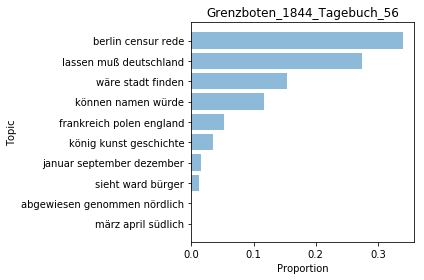

In [29]:
visualization.plot_doc_topics(doc_topics, 0)

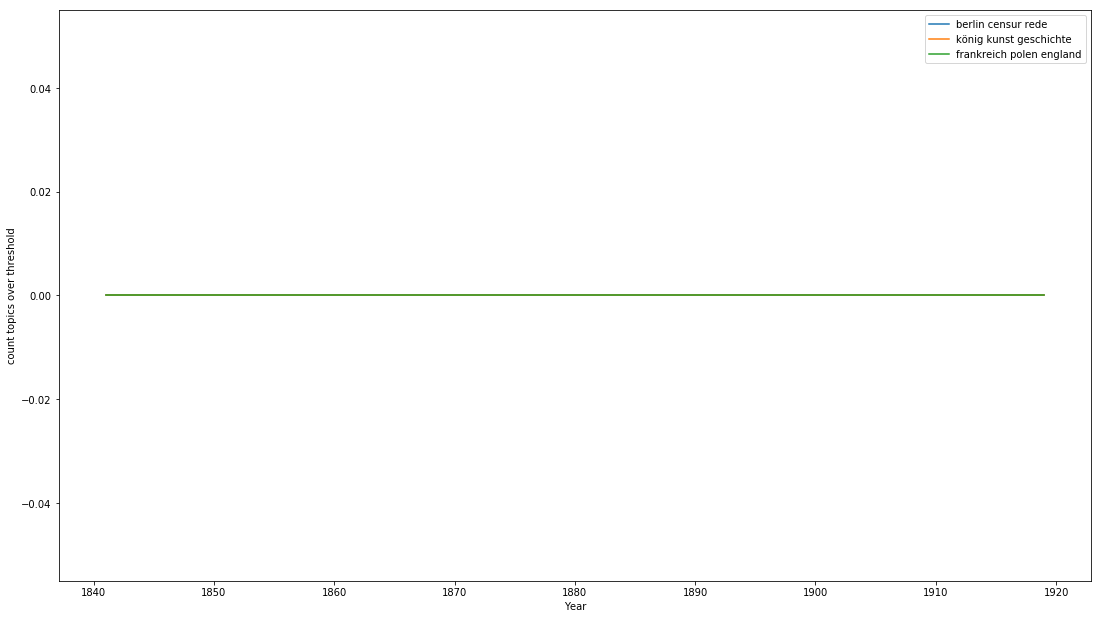

In [31]:
visualization.show_topic_over_time(doc_topics, labels=['berlin censur rede', 'könig kunst geschichte', 'frankreich polen england'], threshold=0.1, starttime=1841, endtime=1920)